## Learning to rank with LambdaMART

In this notebook we apply the LambdaMART, a pairwise learning to rank method, to a text search data set. We use the XGBoost implementation of LambdaMART. 

In [371]:
graphviz.__version__

'0.13.2'

In [372]:
import numpy as np
import pickle
import xgboost as xgb
import graphviz
import matplotlib
import math
import pandas as pd

## Data

The data we use is the Microsoft MSLR-10K dataset, and can be downloaded [here](https://www.microsoft.com/en-us/research/project/mslr/).

The data is a LETOR data set (LEarning TO Rank), of the form: "reference lable (ie ranking given by human), query id, query-url pairs (length 136 feature vec)". It is commonly used for learning to rank benchmarking. 

The data has been pre-processed by a bash script which stores grouping information from the query ids in a .txt.group file, and removes the query id from the raw datasets.  

In [377]:
def get_data(file_loc):
    f = open(file_loc, 'r')
    data = []
    lines = list(f)
    for line in lines:
#         print(line)
        new_arr = []
        arr = line.split(' #')[0].split()
        ''' Get the score and query id '''
        score = arr[0]
        q_id = arr[1].split(':')[1]
        new_arr.append(int(score))
        new_arr.append(int(q_id))
        arr = arr[2:]
        ''' Extract each feature from the feature vector '''
        for el in arr:
            new_arr.append(float(el.split(':')[1]))
        data.append(new_arr)
        f.close()
    return np.array(data)

input_df = pd.read_csv('qac_train.csv', sep = '\t')
train_df = input_df[['relevance_score', 'q_code', 'len_prefix', 'len_suffix', 'len_full', 'word_len_prefix','word_len_suffix', 'word_len_full', 'end_space', 'fre_unigrams', 'fre_bigrams', 'fre_trigrams']] 

input_test_df = pd.read_csv('qac_test.csv', sep = '\t')
test_df = input_test_df[['relevance_score', 'q_code', 'len_prefix', 'len_suffix', 'len_full', 'word_len_prefix','word_len_suffix', 'word_len_full', 'end_space', 'fre_unigrams', 'fre_bigrams', 'fre_trigrams']] 


mpc_input_df = pd.read_csv('mpc_train.csv', sep = '\t')
mpc_train_df = mpc_input_df[['relevance_score', 'q_code', 'len_prefix', 'len_suffix', 'len_full', 'word_len_prefix','word_len_suffix', 'word_len_full', 'end_space', 'fre_unigrams', 'fre_bigrams', 'fre_trigrams']] 

mpc_input_test_df = pd.read_csv('mpc_test.csv', sep = '\t')
mpc_test_df = mpc_input_test_df[['relevance_score', 'q_code', 'len_prefix', 'len_suffix', 'len_full', 'word_len_prefix','word_len_suffix', 'word_len_full', 'end_space', 'fre_unigrams', 'fre_bigrams', 'fre_trigrams']] 


### Show the data

#### Synthetic QAC data

In [410]:
import qgrid

train_df

relevance_score  q_code  len_prefix  len_suffix  len_full  \
0                    1  656177           5          79        84   
1                    0  656177           5           2         7   
2                    0  656177           5           2         7   
3                    0  656177           5           3         8   
4                    0  656177           5           3         8   
...                ...     ...         ...         ...       ...   
11998                0  896362          23          18        36   
11999                1  199133          24          17        41   
12000                0  199133          24          10        28   
12001                1  982209          25          16        41   
12002                0  982209          25          10        28   

       word_len_prefix  word_len_suffix  word_len_full  end_space  \
0                    1               13             14          1   
1                    1                1              2          1   
2                    1                1              2          1   
3                    1                1              2          1   
4                    1                1              2          1   
...                ...              ...            ...        ...   
11998                4                3              6          0   
11999                4                2              6          0   
12000                4                1              4          0   
12001                4                2              6          0   
12002                4                1              4          0   

       fre_unigrams  fre_bigrams  fre_trigrams  
0          2.073568     0.031434      0.144578  
1          1.001322     0.000000      0.000000  
2          0.994273     0.000000      0.000000  
3          0.845154     0.000000      0.000000  
4          0.620264     0.000000      0.000000  
...             ...          ...           ...  
11998      0.427533     0.220039      0.253012  
11999      1.406608     0.220039      0.265060  
12000      0.402423     0.206287      0.240964  
12001      1.406608     0.220039      0.265060  
12002      0.402423     0.206287      0.240964  

[12003 rows x 12 columns]

#### MPC data

In [411]:
# qgrid.show_grid(mpc_train_df)
mpc_train_df

relevance_score  q_code  len_prefix  len_suffix  len_full  \
0                    1  236447           5          79        84   
1                    1  571398           6          78        84   
2                    1  830113           7          77        84   
3                    1   92767           8          76        84   
4                    1  524616           9          75        84   
...                ...     ...         ...         ...       ...   
10447                1  233124          12           6        18   
10448                1  490520          13           5        18   
10449                1  746293          14           4        18   
10450                1     120          15           3        18   
10451                1  247562          16           2        18   

       word_len_prefix  word_len_suffix  word_len_full  end_space  \
0                    1               13             14          1   
1                    2               12             14          0   
2                    2               12             14          1   
3                    3               11             14          0   
4                    3               11             14          0   
...                ...              ...            ...        ...   
10447                2                1              3          1   
10448                3                0              3          0   
10449                3                0              3          0   
10450                3                0              3          0   
10451                3                0              3          0   

       fre_unigrams  fre_bigrams  fre_trigrams  
0          2.073568     0.031434      0.144578  
1          2.073568     0.031434      0.144578  
2          2.073568     0.031434      0.144578  
3          2.073568     0.031434      0.144578  
4          2.073568     0.031434      0.144578  
...             ...          ...           ...  
10447      0.075991     0.007859      0.012048  
10448      0.075991     0.007859      0.012048  
10449      0.075991     0.007859      0.012048  
10450      0.075991     0.007859      0.012048  
10451      0.075991     0.007859      0.012048  

[10452 rows x 12 columns]

In [381]:
# Synthetic QAC
training_data = xgb.DMatrix(train_df.iloc[:,1:], train_df.iloc[:,0])
testing_data = xgb.DMatrix(test_df.iloc[:,1:])

# MPC 
mpc_training_data = xgb.DMatrix(mpc_train_df.iloc[:,1:], mpc_train_df.iloc[:,0])
mpc_testing_data = xgb.DMatrix(mpc_test_df.iloc[:,1:])

In [382]:
relevance_labels = test_df['relevance_score']
# relevance_labels
mpc_relevance_labels = mpc_test_df['relevance_score']

# testing_data

## Building Synthetic QAC Model

We now set the model parameters:

'max_depth' = number of layers in the tree
'eta' = step shrinkage size, used to prevent overfitting
'silent' = if 1, doesn't print updates. 
'objective' = which method is used/which objective function is minimised. 'rank:pairwise' implements LambdaMART.
'num_round' = number of boosting rounds. 

In [384]:
param = {'max_depth':6, 'eta':0.3, 'silent':0, 'objective':'rank:pairwise', 'num_round':10}

In [385]:
model = xgb.train(param, training_data)

[21:18:30] WARNING: /Users/anweshcr7/Downloads/Q3_tud/IR/ir_group3/xgboost/src/learner.cc:480: 
Parameters: { num_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




## Visualising the model

The model takes the form of a decision tree, where splits at nodes are conditional on the inputted features in the feature vector for each query.  

In [386]:
%matplotlib inline

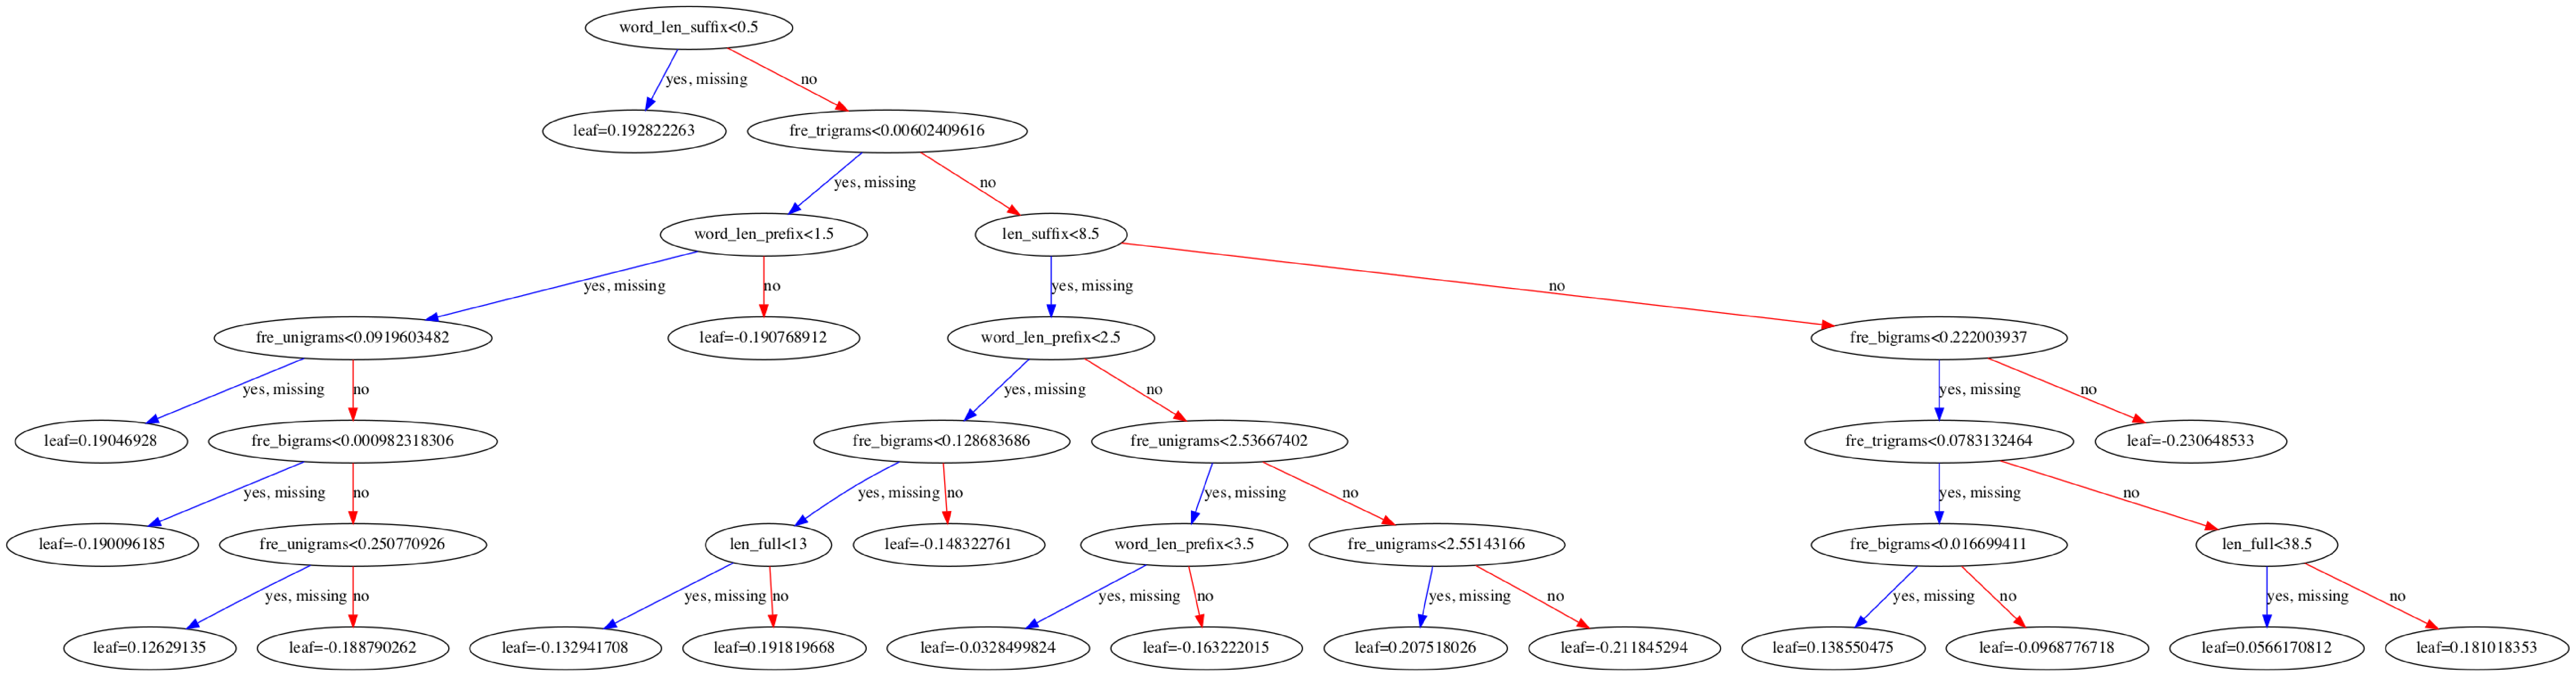

In [387]:
xgb.plot_tree(model, num_trees=3)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)

It is possible to look a the importance of each of the 10 features within the model. In the feature plot below we see that the most 'important' feature in determining the output of the model for a given input. These are n-gram and length based features. 


In [388]:
ax = xgb.plot_importance(model, color='red')
fig = ax.figure
fig.set_size_inches(10, 10)

## Making predictions

'preds' contains predicted relelvance values for all of the queries in the testing data set. We want to compute the normalised discounted cumulative gain, or ndgc, of the results, in order to quantify the goodness of the model. This will allow us to compare models and tuning parameters. 

Predictions are made by passing a feature vector from the testing data set through the decision tree, ending at a leaf which gives a numerical value. The numerical value represents the relavance of that document for that query. 

In [389]:
preds = model.predict(testing_data)

In [390]:
preds

array([1.5120326 , 0.62416434, 1.5120326 , ..., 0.62416434, 0.62416434,
       0.62416434], dtype=float32)

In [412]:
# predicted_scores
input_test_df['scores'] = pd.Series(preds)
import qgrid
# qgrid.show_grid(test_df)
input_test_df

output_df = input_test_df[['q_code','query', 'prefix', 'candidate', 'scores', 'relevance_score']]
# qgrid.show_grid(output_df)
output_df

q_code                                      query  \
0     774496  palm beach county supervisor of elections   
1     774496  palm beach county supervisor of elections   
2     577461  palm beach county supervisor of elections   
3     577461  palm beach county supervisor of elections   
4     439992  palm beach county supervisor of elections   
...      ...                                        ...   
2996  586395                  lee county clerk of court   
2997  586395                  lee county clerk of court   
2998  586395                  lee county clerk of court   
2999  586395                  lee county clerk of court   
3000  586395                  lee county clerk of court   

                            prefix                                  candidate  \
0       palm beach county supervis  palm beach county supervisor of elections   
1       palm beach county supervis               palm beach county supervisor   
2      palm beach county superviso  palm beach county supervisor of elections   
3      palm beach county superviso               palm beach county supervisor   
4     palm beach county supervisor  palm beach county supervisor of elections   
...                            ...                                        ...   
2996      lee county clerk of cour               lee county clerk of court in   
2997      lee county clerk of cour              lee county clerk of court for   
2998      lee county clerk of cour           lee county clerk of courtyard by   
2999      lee county clerk of cour            lee county clerk of court cases   
3000      lee county clerk of cour           lee county clerk of court system   

        scores  relevance_score  
0     1.512033                1  
1     0.624164                0  
2     1.512033                1  
3     0.624164                0  
4     1.512033                1  
...        ...              ...  
2996  0.404325                0  
2997  0.624164                0  
2998  0.624164                0  
2999  0.624164                0  
3000  0.624164                0  

[3001 rows x 6 columns]

In [413]:
# Save to file
# output_df[['prefix','query', 'candidate', 'scores','relevance_score']].to_csv('qac_results.csv', sep='\t')
# output_df = pd.read_csv('check.csv', sep = '\t')

### Mean Reciprocal Rank

In [414]:
def calculate_mrr(df):
    df_by_qid = df.groupby('q_code')
    num_queries = len(df_by_qid)
    reciprocal_sum = 0
    mrr = 0
    for i in range(num_queries):
        ranked_list = list(df_by_qid)[i][1]
        ranked_list = ranked_list[:10]
        ranked_list = ranked_list.sort_values('scores', ascending = False)
        ranked_list = ranked_list.reset_index(drop=True)
#         ranked_list
#         break
        rank = (ranked_list.index[ranked_list['relevance_score'] == 1].values[0]) + 1
        reciprocal_sum = reciprocal_sum + (1/rank)
        mrr = reciprocal_sum/num_queries
    return mrr

In [404]:
# Synthetic QAC MRR value ~ seems high... but then limited data.
# New increased value has been obtained
calculate_mrr(output_df)

0.9709876543209875

## Building the MPC model

In [398]:
## Visualising the model

mpc_model = xgb.train(param, mpc_training_data)

%matplotlib inline

xgb.plot_tree(mpc_model, num_trees=3)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)


[21:25:51] WARNING: /Users/anweshcr7/Downloads/Q3_tud/IR/ir_group3/xgboost/src/learner.cc:480: 
Parameters: { num_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [400]:
ax = xgb.plot_importance(mpc_model, color='blue')
fig = ax.figure
fig.set_size_inches(10, 10)

In [415]:
## Making predictions
mpc_preds = mpc_model.predict(mpc_testing_data)

# predicted_scores
mpc_input_test_df['scores'] = pd.Series(mpc_preds)

mpc_output_df = mpc_input_test_df[['q_code','query', 'prefix', 'candidate', 'scores', 'relevance_score']]
# qgrid.show_grid(mpc_output_df)
mpc_output_df

q_code                      query                    prefix  \
0     504605         auto tuneup clinic         auto tuneup clini   
1     760027        auto tune up clinic                     auto    
2     760027        auto tune up clinic                     auto    
3     760027        auto tune up clinic                     auto    
4     760027        auto tune up clinic                     auto    
...      ...                        ...                       ...   
2609  460555  lee county clerk of court    lee county clerk of co   
2610  260684  lee county clerk of court   lee county clerk of cou   
2611  260684  lee county clerk of court   lee county clerk of cou   
2612   60283  lee county clerk of court  lee county clerk of cour   
2613   60283  lee county clerk of court  lee county clerk of cour   

                        candidate    scores  relevance_score  
0              auto tuneup clinic  2.399954                1  
1             auto tune up clinic -0.192929                1  
2              auto tuneup clinic  1.729455                0  
3                    auto 20parts -0.001523                0  
4     auto detailing for a living -1.290885                0  
...                           ...       ...              ...  
2609   lee county clerk of courts  2.408064                0  
2610    lee county clerk of court  2.408064                1  
2611   lee county clerk of courts  2.408064                0  
2612    lee county clerk of court  2.408064                1  
2613   lee county clerk of courts  2.408064                0  

[2614 rows x 6 columns]

In [405]:
calculate_mrr(mpc_output_df)

0.891741420746702

By changing sorting the prefixes based the frequency, the results seem to have changed as compared to the report.

### MPC_MRR = 0.89
### QAC_MRR = 0.97

### Normal Distributed Cumulative Gain 
ndcg is a metric commonly used to rate the output of learning to rank models.
ndcg is a measure of the relative goodness of the output of the ranking algorithm, and takes value between 0 and 1, with a 1 denoting that the algorithm has optimally ordered the pages for a query, and a 0 denoting that the pages have been reverse ordered. 

In [36]:
""" this returns 0 if all of the ordered data is undesirable"""
def ndcg_p(ordered_data, p):
    """normalised discounted cumulative gain"""
    if sum(ordered_data)==0:
        return 0
    else:
        indexloop = range(0, p)
        DCG_p = 0
        for index in indexloop:
            current_ratio=(2**(ordered_data[index])-1)*(math.log((float(index)+2), 2)**(-1))
            DCG_p = DCG_p + current_ratio
        ordered_data.sort(reverse=True)  
        K = len(ordered_data)
        indexloop = range(0, K)
        iDCG_p = 0
        for index in indexloop:
            current_ratio=(2**(ordered_data[index])-1)*((math.log((index+2), 2))**(-1))
            iDCG_p = iDCG_p + current_ratio
        return(DCG_p/iDCG_p)

In [409]:
# f = open('../LearningToRank/MSLR-WEB10K/Fold1/test_dat.txt.group', 'r')
# x = f.readlines()
# groups =[]
# for line in x:
#     groups.append(int(line))
# f.close()

In [12]:
testing_labels = testing_data.get_label()

In [407]:
# ## compute ndgc for each query.
# nquerys=range(0,len(groups))
# lower=0
# upper=0
# ndcgs=[]
# for i in nquerys:
#         many=groups[i]
#         upper = upper+many
#         predicted = preds[lower:upper]
#         labled = testing_labels[lower:upper]
#         ordered = [x for _,x in sorted(zip(predicted,labled), reverse=True)]
#         result = ndcg_p(ordered, many)
#         ndcgs.append(result)
#         lower=upper


In [408]:
# ndcgs

For each query we see a number between 0 and 1 denoting how well the pages for that query were ordered. 